<div style="text-align:center">
    <h1><b>KLASIFIKASI IKAN SEHAT DENGAN IKAN TERINFEKSI PENYAKIT BERDASARKAN CITRA KULITNYA</b></h1>
    <h1><b></b></h1>
</div>
<br><br>
<br><br>
<table style="width:100%;">
    <tr>
        <td align="center">
            <img src="UNRAM-LOGO.png" alt="Foto" width="500" height="500">
        </td>
    </tr>
</table>
<br><br>
<br><br>
<div style="text-align:center">
    <h2>Disusun Oleh:</h2>
    <h2>MUHAMMAD ADHITYA NUGRAHA: F1D02310016</h2>
    <h2>MUHAMMAD RIDHO AIDIL FURQON: F1D02310127</h2>
    <h2>IRFAN JAYADI: F1D02310011<h2>
    <h2>MUHAMMAD FARUK WIRA PRABUANA JAMALUDIN: F1D02310147</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<div style="text-align:center">
    <h2>UNIVERSITAS MATARAM</h2>
    <h2>FAKULTAS TEKNIK</h2>
    <h2>TEKNIK INFORMATIKA</h2>
    <h2>2024/2025</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>


## Latar Belakang


In [170]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

DATA LOADING

In [171]:
data = []
labels = []
file_name = []
target_size = (256, 256)
for sub_folder in os.listdir("Dataset"):
    sub_folder_files = os.listdir(os.path.join("Dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, target_size)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)



Data Understanding

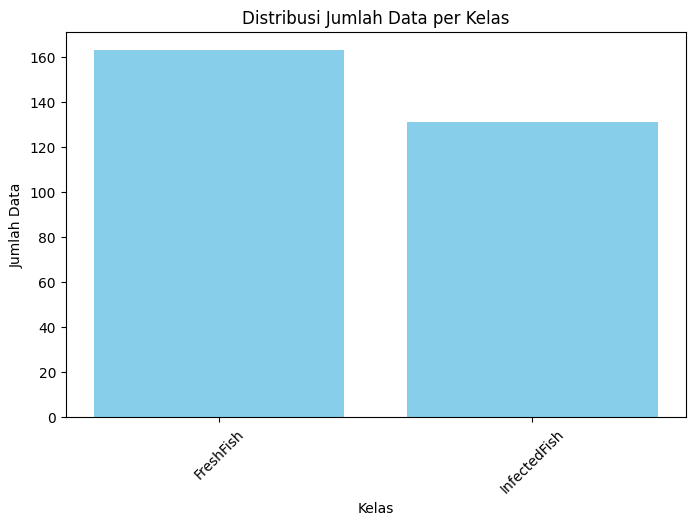

In [172]:
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xticks(rotation=45)
plt.show()

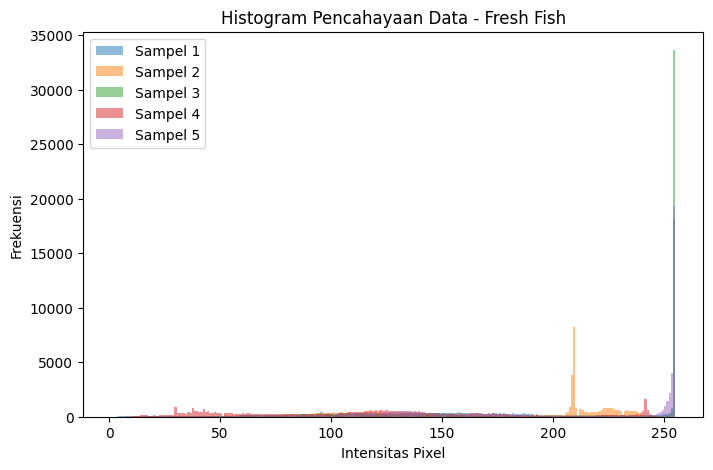

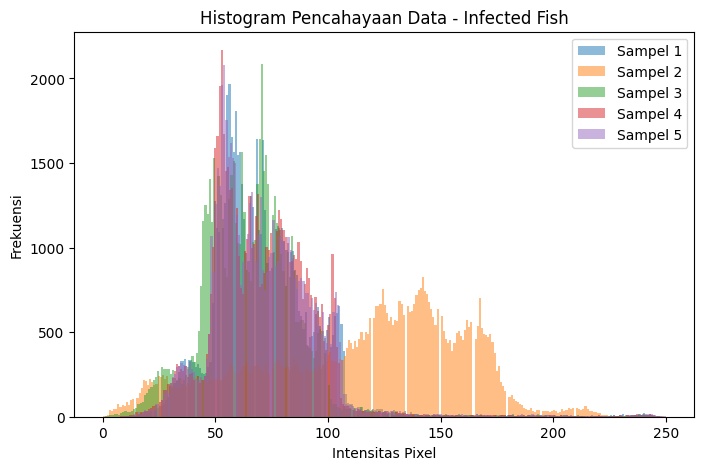

In [173]:
fresh_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "FreshFish"]
infected_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "InfectedFish"]

plt.figure(figsize=(8, 5))
for i in range(min(5, len(fresh_fish_samples))):
    img = fresh_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Fresh Fish")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(min(5, len(infected_fish_samples))):  
    img = infected_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Infected Fish")
plt.legend()
plt.show()

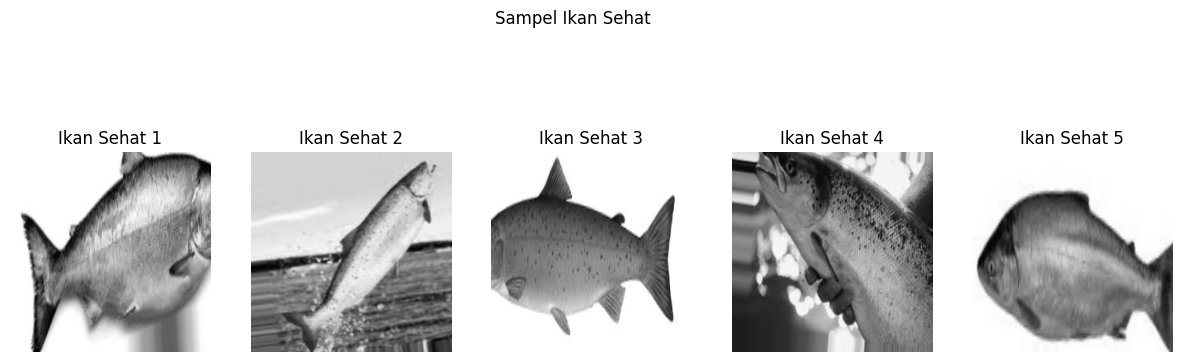

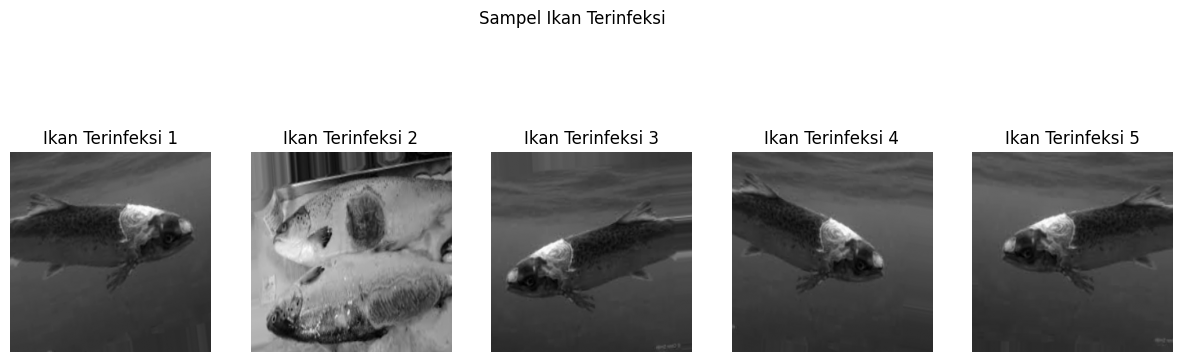

In [174]:
# Menampilkan sampel ikan sehat
fig, axes = plt.subplots(1, min(5, len(fresh_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(fresh_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(fresh_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Sehat {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Sehat")
plt.show()

fig, axes = plt.subplots(1, min(5, len(infected_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(infected_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(infected_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Terinfeksi {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Terinfeksi")
plt.show()

DEFINE DATA AUGMENTATION

In [175]:
augmented = {
    'data': [],
    'labels': [],
    'filenames': []
}

# Proses augmentasi
for i in range(len(data)):
    img = data[i]
    label = labels[i]
    filename = file_name[i]

    # 1. Flip Horizontal
    img_flip_h = cv.flip(img, 1)

    # 2. Flip Vertikal
    img_flip_v = cv.flip(img, 0)

    # 3. Rotasi 90 Derajat
    img_rot_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

    # 4. Rotasi 180 Derajat
    img_rot_180 = cv.rotate(img, cv.ROTATE_180)

    # 5. Translasi (geser gambar)
    rows, cols = img.shape[:2]
    M = np.float32([[1, 0, 20], [0, 1, 20]])  # Geser 20 piksel kanan & bawah
    img_translated = cv.warpAffine(img, M, (cols, rows))

    # Simpan semua hasil ke dalam dictionary 'augmented'
    augmented_images = [
        (img_flip_h, 'flip_h'),
        (img_flip_v, 'flip_v'),
        (img_rot_90, 'rot_90'),
        (img_rot_180, 'rot_180'),
        (img_translated, 'translated')
    ]

    for img_aug, suffix in augmented_images:
        augmented['data'].append(img_aug)
        augmented['labels'].append(label)
        augmented['filenames'].append(f"{filename}_{suffix}")

# Tampilkan hasil
print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(augmented['data']))

Jumlah data sebelum augmentasi: 294
Jumlah data setelah augmentasi: 1470


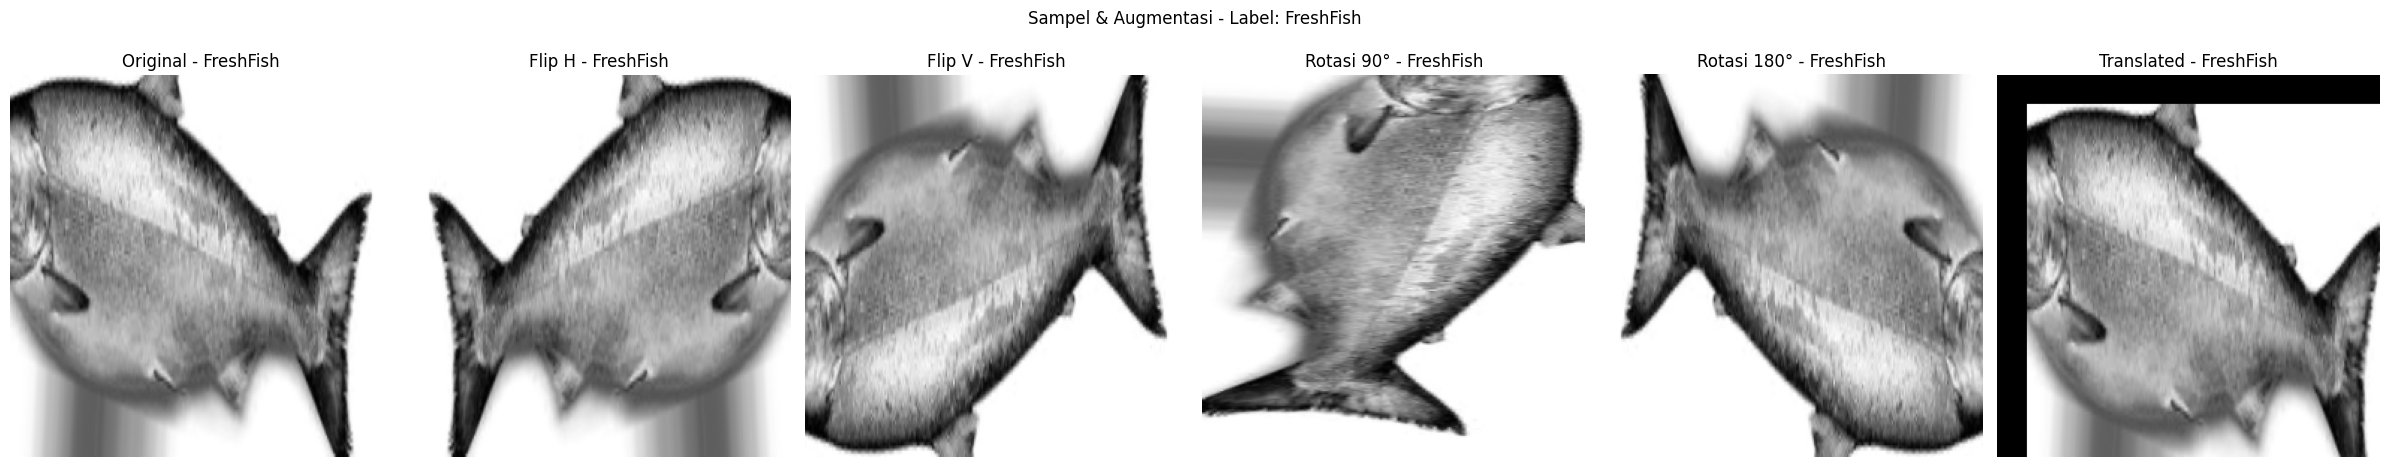

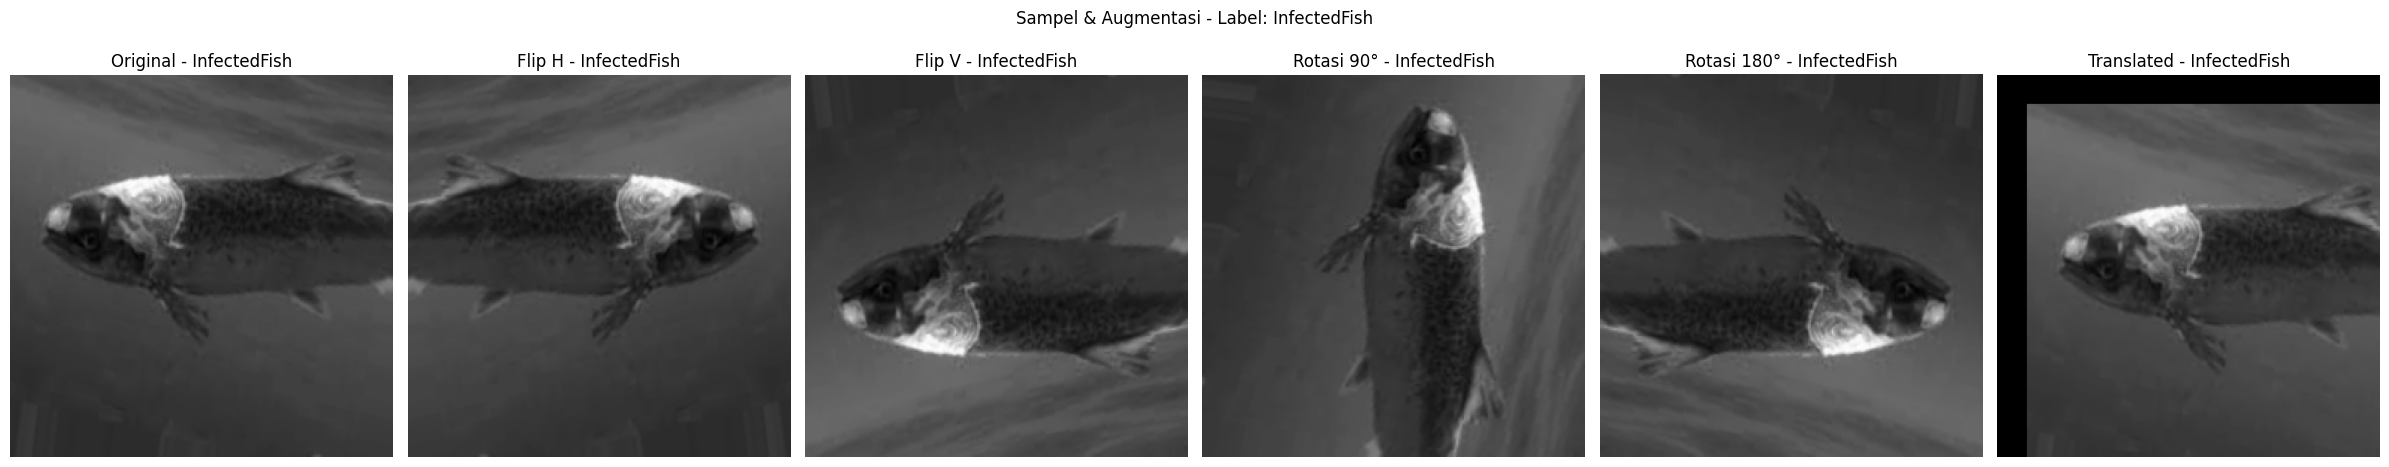

In [176]:
# Ambil label unik dari data yang telah di-augmentasi
unique_labels = np.unique(augmented['labels'])

for label in unique_labels:
    # Ambil semua gambar yang label-nya sama
    samples = [augmented['data'][i] for i in range(len(augmented['labels'])) if augmented['labels'][i] == label]

    if len(samples) > 0:
        sample_img = samples[0]  # Ambil satu contoh gambar

        # Translasi tambahan
        rows, cols = sample_img.shape[:2]
        M_trans = np.float32([[1, 0, 20], [0, 1, 20]])
        img_translated = cv.warpAffine(sample_img, M_trans, (cols, rows))

        # Siapkan tampilan
        fig, axes = plt.subplots(1, 6, figsize=(24, 5))
        augment_titles = ["Original", "Flip H", "Flip V", "Rotasi 90°", "Rotasi 180°", "Translated"]

        # Daftar gambar hasil augmentasi
        augmentations = [
            sample_img,
            cv.flip(sample_img, 1),
            cv.flip(sample_img, 0),
            cv.rotate(sample_img, cv.ROTATE_90_CLOCKWISE),
            cv.rotate(sample_img, cv.ROTATE_180),
            img_translated
        ]

        # Tampilkan semua hasil dalam satu baris
        for i in range(6):
            axes[i].imshow(augmentations[i], cmap="gray")
            axes[i].set_title(f"{augment_titles[i]} - {label}")
            axes[i].axis("off")

        plt.suptitle(f"Sampel & Augmentasi - Label: {label}")
        plt.tight_layout()
        plt.show()

PREPROSSESING

In [177]:
def normalize(img):
    return cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

def histogram_equalization(img):
    return cv.equalizeHist(img)

def mean_filter(img, ksize=3):
    return cv.blur(img, (ksize, ksize))

def median_filter(img, ksize=3):
    return cv.medianBlur(img, ksize)

def morphological_opening(img, ksize=3):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (ksize, ksize))
    return cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

def morphological_closing(img, ksize=3):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (ksize, ksize))
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

def prewitt_operator(img):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    x = cv.filter2D(img, -1, kernelx)
    y = cv.filter2D(img, -1, kernely)
    return cv.addWeighted(x, 0.5, y, 0.5, 0)


In [178]:
def prepro1(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    return eq

# Percobaan 2: + Mean + Median filter
def prepro2(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    mean = mean_filter(eq)
    median = median_filter(mean)
    return median

# Percobaan 3: + Opening + Closing + Prewitt
def prepro3(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    mean = mean_filter(eq)
    median = median_filter(mean)
    open_ = morphological_opening(median)
    close = morphological_closing(open_)
    prewitt = prewitt_operator(close)
    return prewitt

In [179]:
# Inisialisasi list untuk menyimpan hasil preprocessing
dataPreprocessed_1 = []
dataPreprocessed_2 = []
dataPreprocessed_3 = []

# Ambil data hasil augmentasi
augmented_data = augmented['data']

# Lakukan preprocessing untuk masing-masing percobaan
for img in augmented_data:
    dataPreprocessed_1.append(prepro1(img))
    dataPreprocessed_2.append(prepro2(img))
    dataPreprocessed_3.append(prepro3(img))

# Tentukan percobaan yang ingin dipakai (misalnya ke-1, ke-2, atau ke-3)
percobaan_ke = 3

# Pilih hasil preprocessing sesuai percobaan
if percobaan_ke == 1:
    dataPreprocessed = dataPreprocessed_1
elif percobaan_ke == 2:
    dataPreprocessed = dataPreprocessed_2
elif percobaan_ke == 3:
    dataPreprocessed = dataPreprocessed_3
else:
    raise ValueError("Hanya mendukung percobaan ke-1, 2, atau 3.")


FEATURE EXTRACTION

In [180]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [181]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [182]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [183]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [184]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [185]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [186]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [187]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [188]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [189]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [190]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [191]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [192]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [193]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [194]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [195]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [196]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Write the extraction's results to CSV

In [197]:
dataTable = {'Filename': augmented['filenames'], 'Label': augmented['labels'],
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,aug_0_1014.png_flip_h,FreshFish,68.930576,125.513479,51.925031,100.361246,0.582794,0.556038,0.618050,0.537261,...,0.205561,0.182948,0.442863,0.431760,0.453388,0.427724,0.920212,0.854941,0.939864,0.884010
1,aug_0_1014.png_flip_v,FreshFish,84.792586,113.337116,29.906648,103.136332,0.571180,0.537054,0.595635,0.520237,...,0.183384,0.162356,0.417975,0.408693,0.428233,0.402935,0.899243,0.865457,0.964402,0.877567
2,aug_0_1014.png_rot_90,FreshFish,29.906648,113.337116,84.792586,103.136332,0.595635,0.537054,0.571180,0.520237,...,0.174703,0.162356,0.428233,0.408693,0.417975,0.402935,0.964402,0.865457,0.899243,0.877567
3,aug_0_1014.png_rot_180,FreshFish,67.352298,114.436140,30.670588,68.564491,0.603380,0.552398,0.627422,0.574067,...,0.219029,0.202996,0.461921,0.445463,0.468006,0.450551,0.895212,0.822099,0.952200,0.893410
4,aug_0_1014.png_translated,FreshFish,89.646385,176.214764,54.799341,96.021115,0.671519,0.629129,0.688626,0.649938,...,0.330170,0.311452,0.567467,0.552041,0.574604,0.558079,0.923008,0.849032,0.952936,0.917736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,aug_0_9876.png_flip_h,InfectedFish,47.339354,170.511142,91.311336,87.084521,0.547815,0.452537,0.513750,0.482734,...,0.130380,0.120960,0.373194,0.339430,0.361082,0.347793,0.925063,0.730210,0.855416,0.862211
1466,aug_0_9876.png_flip_v,InfectedFish,41.353922,185.876832,105.838863,89.341869,0.639779,0.554637,0.605991,0.575202,...,0.235625,0.222696,0.501820,0.463331,0.485412,0.471907,0.948553,0.769066,0.868278,0.889002
1467,aug_0_9876.png_rot_90,InfectedFish,105.838863,185.876832,41.353922,89.341869,0.605991,0.554637,0.639779,0.575202,...,0.251824,0.222696,0.485412,0.463331,0.501820,0.471907,0.868278,0.769066,0.948553,0.889002
1468,aug_0_9876.png_rot_180,InfectedFish,40.255821,119.477186,94.501379,132.070281,0.533557,0.462430,0.513761,0.452094,...,0.118159,0.103455,0.354081,0.326332,0.343743,0.321645,0.936585,0.811883,0.851056,0.792055


<Axes: >

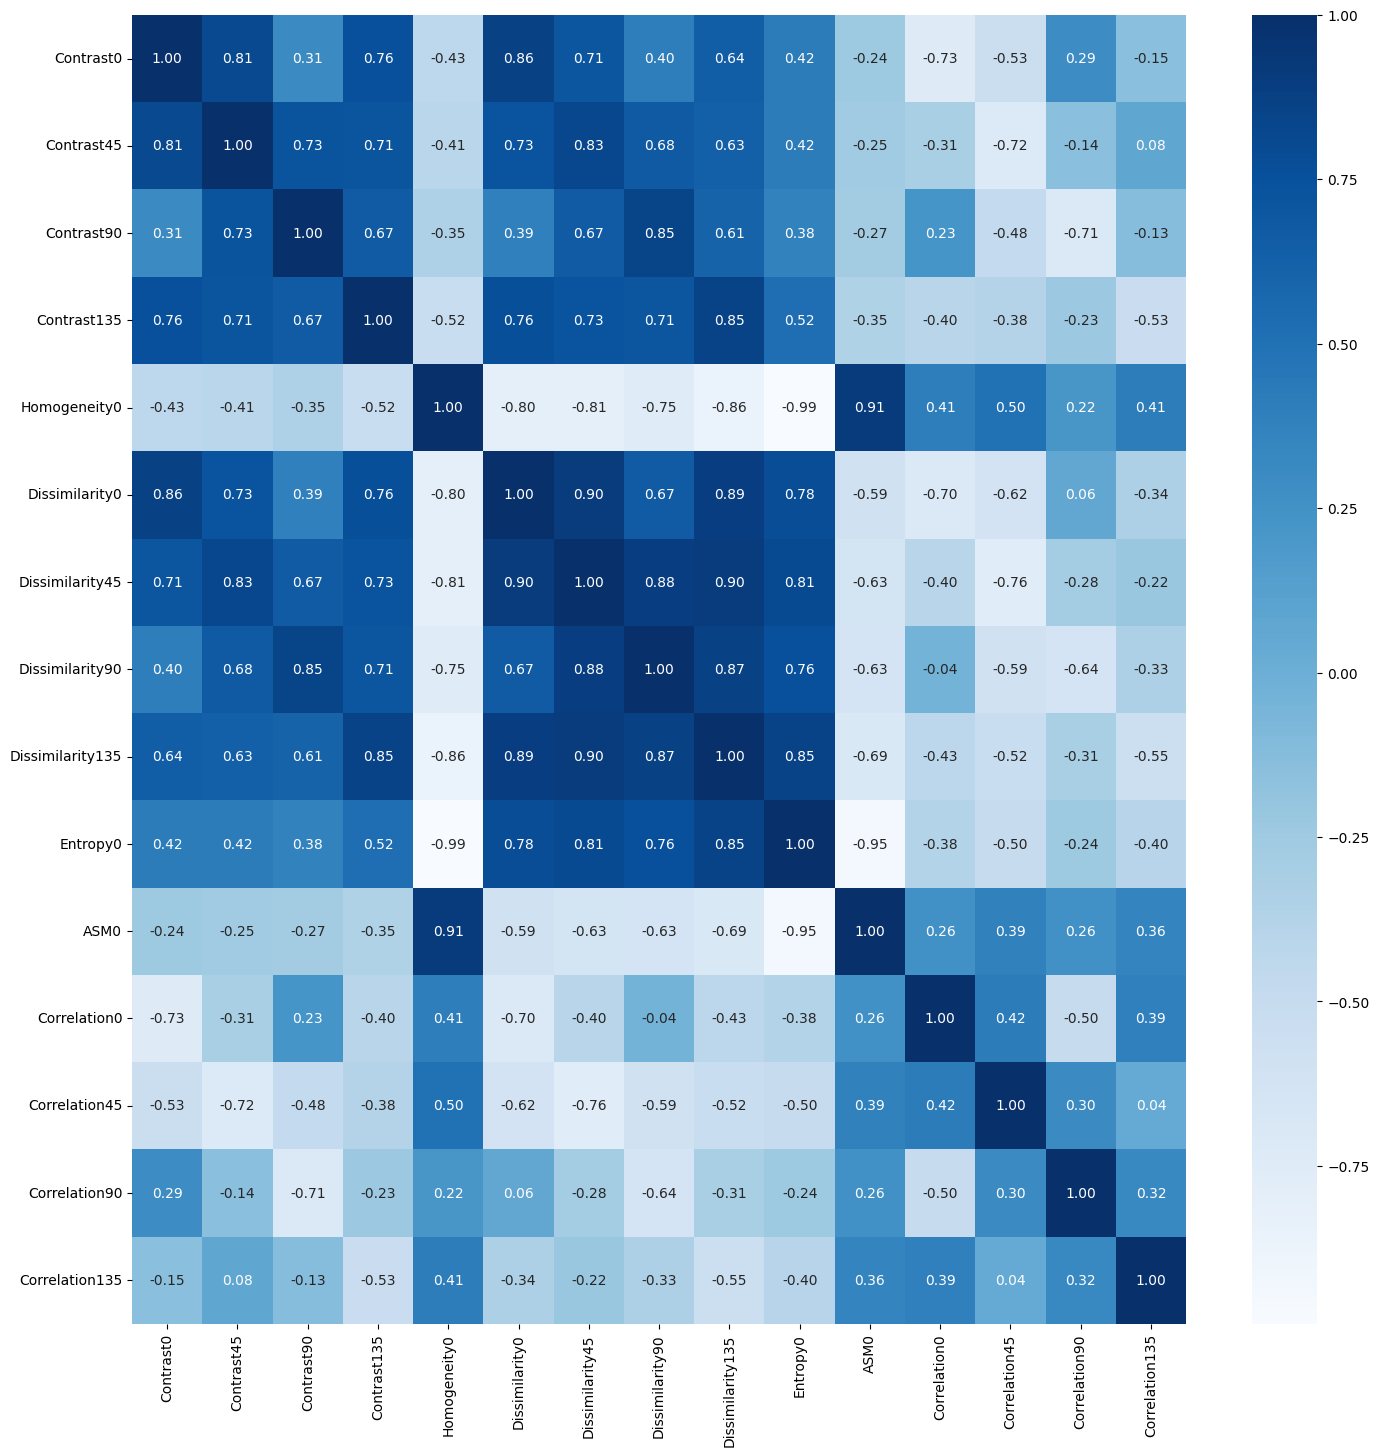

In [198]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

Splitting Data

In [199]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1176, 15)
(294, 15)


Feature Normalization

In [200]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Modeling
Define Model

In [201]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Train Random Forest Classifier

In [202]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.99      1.00      0.99       654
InfectedFish       0.99      0.98      0.99       522

    accuracy                           0.99      1176
   macro avg       0.99      0.99      0.99      1176
weighted avg       0.99      0.99      0.99      1176

[[651   3]
 [  8 514]]
Accuracy: 0.9906462585034014

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.91      0.95      0.93       161
InfectedFish       0.94      0.88      0.91       133

    accuracy                           0.92       294
   macro avg       0.92      0.92      0.92       294
weighted avg       0.92      0.92      0.92       294

[[153   8]
 [ 16 117]]
Accuracy: 0.9183673469387755


Train SVM Classifier

In [203]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.89      0.93      0.91       654
InfectedFish       0.91      0.85      0.88       522

    accuracy                           0.90      1176
   macro avg       0.90      0.89      0.90      1176
weighted avg       0.90      0.90      0.90      1176

[[609  45]
 [ 76 446]]
Accuracy: 0.8971088435374149

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.88      0.98      0.93       161
InfectedFish       0.97      0.84      0.90       133

    accuracy                           0.91       294
   macro avg       0.92      0.91      0.91       294
weighted avg       0.92      0.91      0.91       294

[[157   4]
 [ 21 112]]
Accuracy: 0.9149659863945578


Train KNN Classifier

In [204]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.95      0.97      0.96       654
InfectedFish       0.96      0.93      0.94       522

    accuracy                           0.95      1176
   macro avg       0.95      0.95      0.95      1176
weighted avg       0.95      0.95      0.95      1176

[[633  21]
 [ 36 486]]
Accuracy: 0.951530612244898

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.90      0.95      0.92       161
InfectedFish       0.94      0.87      0.90       133

    accuracy                           0.91       294
   macro avg       0.92      0.91      0.91       294
weighted avg       0.92      0.91      0.91       294

[[153   8]
 [ 17 116]]
Accuracy: 0.9149659863945578


Evaluation With Confusion Matrix

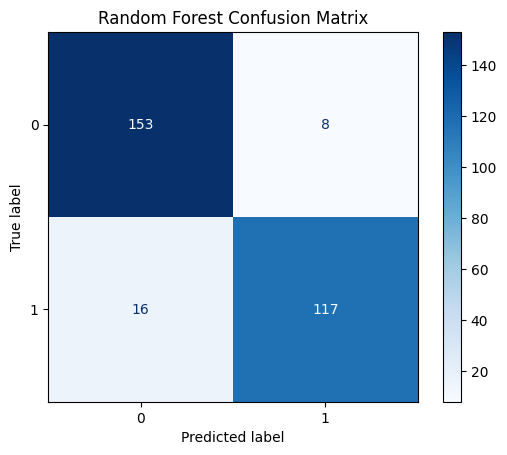

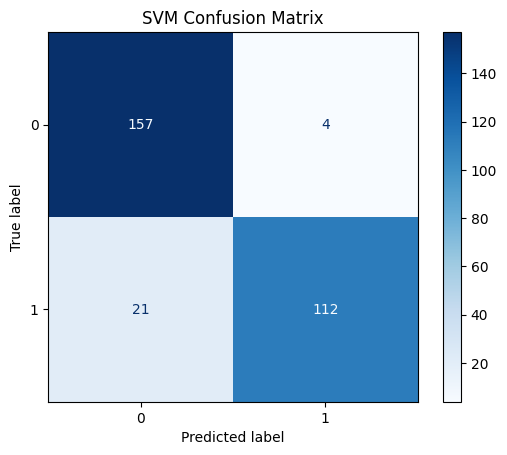

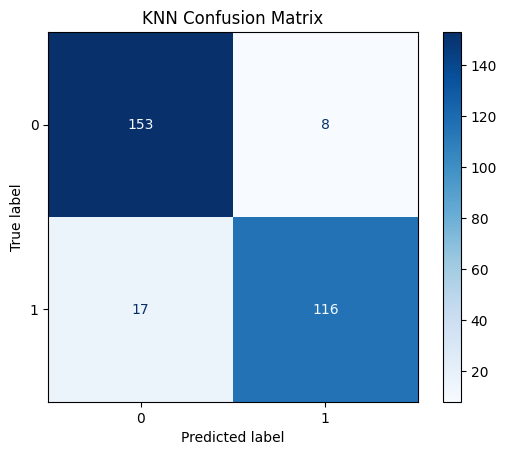

In [205]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")